In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from evo_to_stationary import intEvo, simEvo
from time_study_maps import search_time
import glob
%matplotlib inline
import sys
sys.path.append('../')
from package_global_functions import *

def getTimeEvosPath():
    extSSDpath = getExternalSSDpath()
    if os.path.exists(extSSDpath):
        path = extSSDpath + getProjectFoldername() + '/evo_to_stationary/time_evos_dif_cond'
    else:
        path = '/time_evos_dif_cond'
    return path

def getQPath():
    extSSDpath = getExternalSSDpath()
    if os.path.exists(extSSDpath):
        path = extSSDpath + getProjectFoldername() + '/det_sols_from_polynomial/res_files'
    else:
        path = '/res_files'
    return path

In [2]:
from scipy.ndimage import gaussian_filter1d

def search_time(w,t,evo,sig=0):
    """
    sig=0 -> no gaussian filter; sig != 0 -> apply gaussian filter with this sigma
    """
    if sig:
        evo_mod = gaussian_filter1d(evo, sig)
    else:
        evo_mod = evo
    time = float('nan')
    for i in range(len(evo_mod)-w):
        block_avg = np.average(evo_mod[i:i+w])
        if abs(evo_mod[i+w+1] - block_avg) < t:
            time = i+w+1
            break
    return time

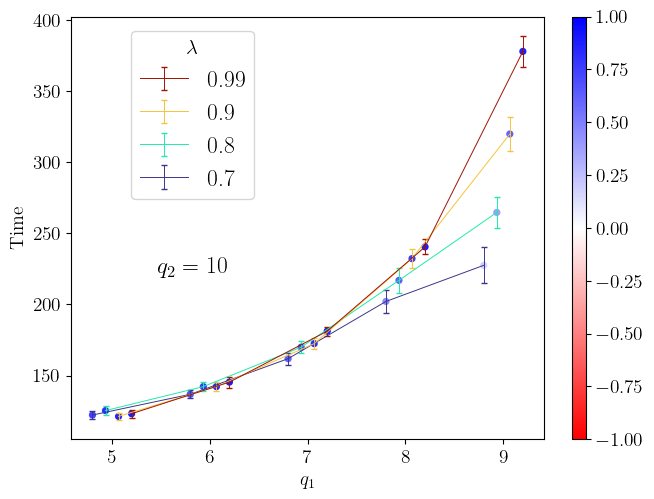

In [13]:
# varying q1 for a set of lambdas:
latexFont(titlesize=14, ticklabelssize=14, labelsize=14)

N, pi1, pi2, q2 = 5000, 0.1, 0.1, 10
q1s = [1,2,3,4,5,6,7,8,9]
q1s = [5,6,7,8,9]

lambs = [0.7, 0.8, 0.9, 0.99]
colors = plt.cm.cool(np.linspace(0,1,len(lambs)))
colors = plt.cm.turbo(np.linspace(0.05,0.95,len(lambs)))
jitterer_ls_q1 = np.linspace(-0.2,0.2, len(lambs))
fig, ax = plt.subplots()

for l,c,jitterer in zip(lambs,colors,jitterer_ls_q1):
    times_q1, times_q1_sigma, Qs_q1 = [], [], []
    for q1 in q1s:
        # get the dataframes with the time evolutions:
        folder = f'time_evo_csv_N_{N}_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}'
        files = glob.glob(f'{getTimeEvosPath()}/{folder}/*')
        dfs = [pd.read_csv(file) for file in files]
        times, Qs = [], []
        for df in dfs:
            # time = search_time(w=10, t=0.0005, evo=df['f2'], sig=20)
            time = search_time(w=75, t=0.0005, evo=df['f2'])
            times.append(time)
            # check value of consensus:
            df['Q'] = df['f2'] - 2*df['f1']
            Q = np.average(df['Q'].iloc[time:])
            Qs.append(Q)
        times_q1.append(np.average(times)), times_q1_sigma.append(np.std(times)/np.sqrt(len(dfs))), Qs_q1.append(np.average(Qs))
    # Consenus markers:
    Q_markers = ['*' if Q>0 else '.' for Q in Qs_q1]
    times_Q_pos = [time for time,Q in zip(times_q1,Qs_q1) if Q>0]
    q1s_pos = [q1 for q1,Q in zip(q1s, Qs_q1) if Q>0]
    times_Q_neg = [time for time,Q in zip(times_q1,Qs_q1) if Q<0]
    q1s_neg = [q1 for q1,Q in zip(q1s, Qs_q1) if Q<0]
    ax.errorbar(q1s+jitterer, times_q1, times_q1_sigma, capsize=2.0, elinewidth=0.7, lw=0.7, marker=None, color=c, label=f'{l}')
    # ax.scatter(q1s_pos, times_Q_pos, marker='*')
    # ax.scatter(q1s_neg, times_Q_neg, marker='.')
    points = ax.scatter(q1s+jitterer, times_q1, c=Qs_q1, cmap='bwr_r', vmin=-1, vmax=1, marker='.', s=70)

cb = fig.colorbar(points, aspect=30, fraction=0.10)

ax.set(xlabel='$q_1$', ylabel='Time')
fig.text(0.23, 0.45, f'$q_2 = {q2}$', fontsize=17)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], title='$\lambda$', fontsize=17, loc=(0.2, 0.6))
fig.tight_layout(pad=0.02)
fig.savefig(f'stat_times_q1_many_l_70_to_99_pi1_{pi1}_pi2_{pi2}_q2_{q2}_N_{N}.tiff')

### Figure for the paper:

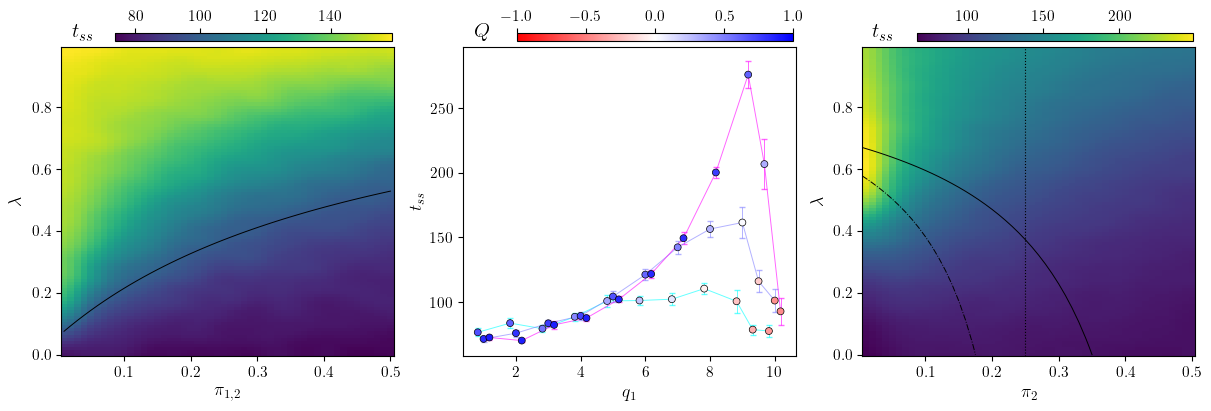

In [17]:
latexFont(titlesize=11, ticklabelssize=11, labelsize=13)

fig, ax = plt.subplots(1,3,figsize=(12, 4), constrained_layout=True)

# LEFT (A): symetric discovery scenario times map
q1, q2, = 7, 10
map = np.load(f'{getTimeEvosPath()}/stat_times_maps/map_times_sim_sym_q1_{q1}_q2_{q2}.npz')
sigma = 2
map_filtered = gaussian_filter(map['time'], sigma=sigma)
im = ax[0].pcolormesh(map['x'], map['y'], map_filtered, cmap='viridis', shading='nearest', rasterized=True)
fig.colorbar(im, ax=ax[0], location='top', fraction=0.05, aspect=35, pad=0.02, shrink=0.83, anchor=(0.96, 1.0))
pathQline = getExternalSSDpath() + getProjectFoldername() + '/det_sols_from_polynomial/res_files'
tline = pd.read_csv(f'{pathQline}/Tline_sym_pis_q1_{float(q1)}_q2_{float(q2)}_f2_2f1.csv')
tline = tline.query('pi >= 0.01')
ax[0].plot(tline['pi'], tline['lambda'], color='xkcd:black', lw=0.7)
ax[0].set_xlabel('$\pi_{1,2}$')
ax[0].set_ylabel('$\lambda$')
fig.text(0.055, 0.92, r"$t_{ss}$", color='xkcd:black')

# RIGHT (C): 
pi1 = 0.25
map = np.load(f'{getTimeEvosPath()}/stat_times_maps/map_times_sim_asym_fixPi1_q1_{q1}_q2_{q2}_pi1_{pi1}.npz')
map_filtered = gaussian_filter(map['time'], sigma=sigma)
im = ax[2].pcolormesh(map['x'], map['y'], map_filtered, cmap='viridis', shading='nearest', rasterized=True)
fig.colorbar(im, ax=ax[2], location='top', fraction=0.05, aspect=35, pad=0.02, shrink=0.83, anchor=(0.96, 1.0))
for x,ls in zip([1, 2], ['-.', '-']):
    tline = pd.read_csv(f'{pathQline}/Tline_asym_fixPi1_pi1_{pi1}_q1_{float(q1)}_q2_{float(q2)}_f2_{int(x)}f1.csv')
    tline = tline.query('pi2 >= 0.005')
    tline = tline.rename(columns={'lambda':'l'})
    i_last_pi2 = tline.query('l != l').iloc[0].name
    tline.at[i_last_pi2, 'l'] = 0.0
    ax[2].plot(tline['pi2'], tline['l'], color='xkcd:black', lw=0.7, ls=ls)
ax[2].set_xlabel('$\pi_{2}$')
ax[2].set_ylabel('$\lambda$')
ax[2].axvline(pi1, ls=':', color='xkcd:black', lw=0.8)
fig.text(0.722, 0.92, r"$t_{ss}$", color='xkcd:black')

# CENTER (B):
N, pi1, pi2, q2 = 5000, 0.1, 0.1, 10.0
q1s = [1,2,3,4,5,6,7,8,9,9.5,10.0]
# q1s = [7,8,9]
# block size, threshold and gaussian filter:
w, t, sig = 50, 5e-4, 0

lambs = [0.3,0.6,0.9]
# lambs = [0.9, ]
colors = plt.cm.cool(np.linspace(0,1,len(lambs)))
jitterer_ls_q1 = np.linspace(-0.18,0.18, len(lambs))

for l,c,jitterer in zip(lambs,colors,jitterer_ls_q1):
    times_q1, times_q1_sigma, Qs_q1 = [], [], []
    for q1 in q1s:
        # get the dataframes with the time evolutions:
        folder = f'time_evo_csv_N_{N}_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}'
        folder_qint = f'time_evo_csv_N_{N}_pi1_{pi1}_pi2_{pi2}_q1_{int(q1)}_q2_{int(q2)}_l_{l}'
        if not os.path.exists(f'{getTimeEvosPath()}/{folder}') and not os.path.exists(f'{getTimeEvosPath()}/{folder_qint}'):
            # call(f'python evo_to_stationary.py {pi} {pi} {q1} {q2} {l} {N} N {np.random.randint(1,1000000)}', shell=True)
            simEvo(pi1, pi2, q1, q2, l, N, ic='N', bots_per_site = [N, 0, 0], max_time = 1000, Nrea=25)
        try:
            files = glob.glob(f'{getTimeEvosPath()}/{folder}/*')
        except FileNotFoundError:
            files = glob.glob(f'{getTimeEvosPath()}/{folder_qint}/*')
        dfs = [pd.read_csv(file) for file in files]
        times, Qs = [], []
        for df in dfs:
            time = search_time(w=w, t=t, evo=df['f2'], sig=sig)
            times.append(time)
            # check value of consensus:
            df['Q'] = df['f2'] - 2*df['f1']
            Q = np.average(df['Q'].iloc[time:])
            Qs.append(Q)
        times_q1.append(np.average(times)), times_q1_sigma.append(np.std(times)/np.sqrt(len(dfs))), Qs_q1.append(np.average(Qs))
    # Consenus markers:
    Q_markers = ['*' if Q>0 else '.' for Q in Qs_q1]
    times_Q_pos = [time for time,Q in zip(times_q1,Qs_q1) if Q>0]
    q1s_pos = [q1 for q1,Q in zip(q1s, Qs_q1) if Q>0]
    times_Q_neg = [time for time,Q in zip(times_q1,Qs_q1) if Q<0]
    q1s_neg = [q1 for q1,Q in zip(q1s, Qs_q1) if Q<0]
    ax[1].errorbar(q1s+jitterer, times_q1, times_q1_sigma, capsize=2.0, elinewidth=0.7, lw=0.7, marker=None, color=c, alpha=0.6, label=f'{l}', zorder=-1)
    # ax.scatter(q1s_pos, times_Q_pos, marker='*')
    # ax.scatter(q1s_neg, times_Q_neg, marker='.')
    points = ax[1].scatter(q1s+jitterer, times_q1, c=Qs_q1, cmap='bwr_r', vmin=-1, vmax=1, marker='.', s=100, linewidths=0.5, edgecolors='k')

cb = fig.colorbar(points, ax=ax[1], location='top', aspect=35, fraction=0.05, pad=0.02, shrink=0.83, anchor=(0.96, 1.0))
fig.text(0.39,0.92, r'$Q$', color='xkcd:black')
ax[1].set(xlabel='$q_1$', ylabel=r'$t_{ss}$')

fig.savefig('stationary_times_multiplot_paper.png')
fig.savefig('stationary_times_multiplot_paper.pdf')

### Join figure time and consensus:

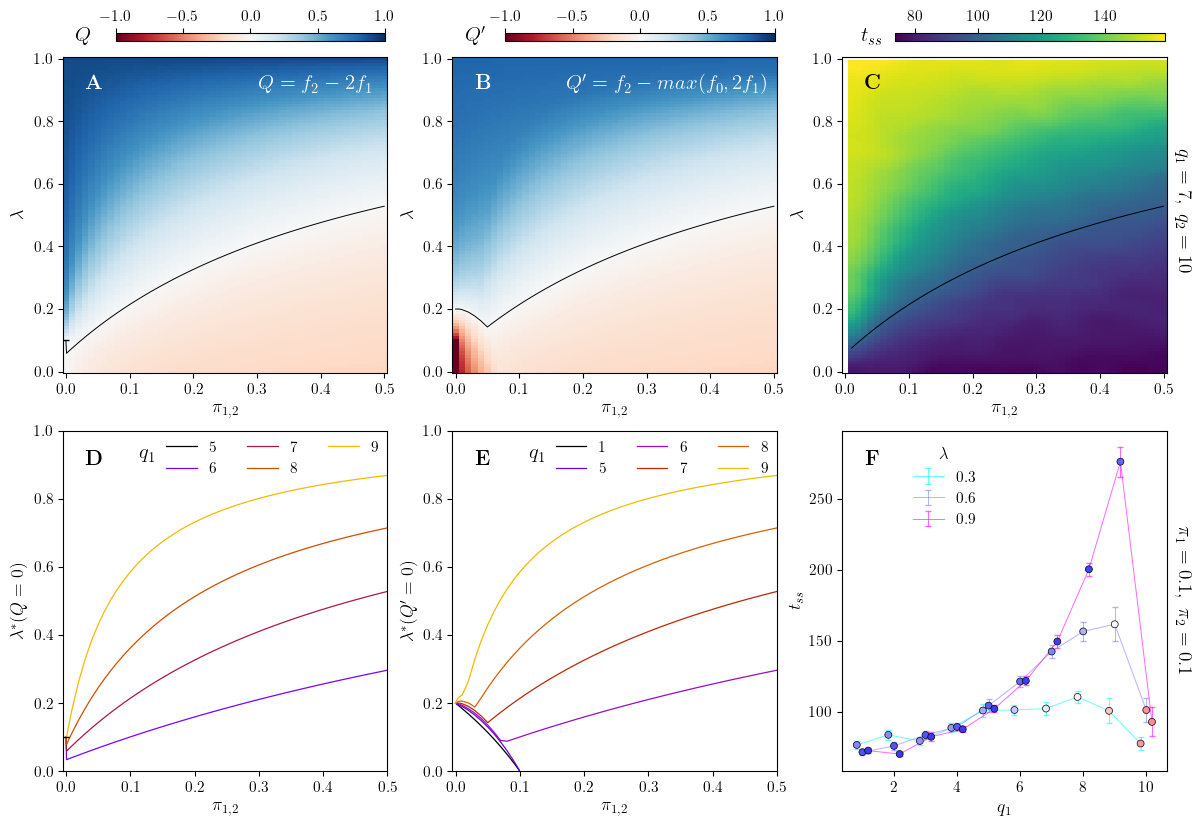

In [5]:
latexFont(titlesize=11, ticklabelssize=11, labelsize=13)
# fig, ax = plt.subplots(2,3, figsize=(12,8.2), constrained_layout=True)
fig, ax = plt.subplots(2,3, figsize=(12,8.2))
fig.subplots_adjust(left=0.05, right=0.97, bottom=0.06, top=0.96, hspace=0.17, wspace=0.2)

# UPPER LEFT: original consensus definition
x = 2
q1, q2 = 7, 10
fsMesh = np.load(f'{getQPath()}/map_sym_q1_{q1}_q2_{q2}_Amp_pi0_l1.npz')
Qmesh = fsMesh['fs'][2] - x*fsMesh['fs'][1]
maxval = np.max(abs(Qmesh))
zLim = [-maxval, maxval]
zLim = [-1, 1]
im = ax[0,0].pcolormesh(fsMesh['x'], fsMesh['y'], Qmesh, cmap='RdBu', shading='nearest', vmin=zLim[0], vmax=zLim[1], rasterized=True)
fig.colorbar(im, ax=ax[0,0], location='top', fraction=0.05, aspect=35, pad=0.02, shrink=0.83, anchor=(0.96, 1.0))
tline = pd.read_csv(f'{getQPath()}/Tline_sym_pis_q1_{float(q1)}_q2_{float(q2)}_f2_{int(x)}f1.csv')
# add the pi = 0.0 point to the tline:
tline.loc[-1] = [0.0, 0.1]
tline.index = tline.index + 1
tline = tline.sort_index()
ax[0,0].plot(tline['pi'], tline['lambda'], color='xkcd:black', lw=0.7)
# marker to signal the special behavior at pi=0:
ax[0,0].plot(0.0, 0.1, color='xkcd:black', marker='_', markersize=5)
# tline = tline.query('pi >= 0.01')
ax[0,0].set_xlabel('$\pi_{1,2}$')
ax[0,0].set_ylabel('$\lambda$')


# LOWER LEFT: original consensus tlines
q1s, q2 = [5, 6,7,8,9], 10
colors = plt.cm.gnuplot(np.linspace(0,0.9,len(q1s)))
x = 2
for q1,c in zip(q1s, colors):
    tline = pd.read_csv(f'{getQPath()}/Tline_sym_pis_q1_{float(q1)}_q2_{float(q2)}_f2_{int(x)}f1.csv')
    tline.loc[-1] = [0.0, 0.1]
    tline.index = tline.index + 1
    tline = tline.sort_index()
    ax[1,0].plot(tline['pi'], tline['lambda'], color=c, lw=0.9, label=f'{q1}')
# marker to signal the special behavior at pi=0:
ax[1,0].plot(0.0, 0.1, color='xkcd:black', marker='_', markersize=5)
ax[1,0].set(xlabel=r'$\pi_{1,2}$', ylabel=r'$\lambda^* (Q=0)$', xlim=(-0.005,0.5), ylim=(0,1)) 
# ax[1,0].legend(title=r'$q_1$', loc=(0.025,0.7), fontsize=11, title_fontsize=12, ncols=2, frameon=False)
ax[1,0].legend(loc=(0.3, 0.85), fontsize=11, title_fontsize=12, ncols=3, frameon=False)
ax[1,0].text(0.235, 0.92, r'$q_1$', transform=ax[1,0].transAxes)


# UPPER CENTER: modified consensus
q1, q2 = 7, 10
f01 = np.maximum(fsMesh['fs'][0], x*fsMesh['fs'][1])
QmodMesh = fsMesh['fs'][2] - f01
maxval = np.max(abs(QmodMesh))
zLim = [-maxval, maxval]
im = ax[0,1].pcolormesh(fsMesh['x'], fsMesh['y'], QmodMesh, cmap='RdBu', shading='nearest', vmin=zLim[0], vmax=zLim[1], rasterized=True)
fig.colorbar(im, ax=ax[0,1], location='top', fraction=0.05, aspect=35, pad=0.02, shrink=0.83, anchor=(0.96, 1.0))
# tline = pd.read_csv(f'{path}/Tline_Qmod_sym_pis_q1_{float(q1)}_q2_{float(q2)}_f2_{int(x)}f1.csv')
tline = pd.read_csv(f'{getQPath()}/Tline_Qmod2_sym_pis_q1_{float(q1)}_q2_{float(q2)}_f2_{int(x)}f1.csv')
# tline = tline.query('pi >= 0.01')
tline.loc[-1] = [0.0, 0.2]
tline.index = tline.index + 1
tline = tline.sort_index()
ax[0,1].plot(tline['pi'], tline['lambda'], color='xkcd:black', lw=0.7)
ax[0,1].set_xlabel('$\pi_{1,2}$')
ax[0,1].set_ylabel('$\lambda$')


# LOWER CENTER:
q1s, q2 = [1, 5, 6, 7, 8, 9], 10
colors = plt.cm.gnuplot(np.linspace(0,0.9,len(q1s)))
x = 2
for q1,c in zip(q1s, colors):
    tline = pd.read_csv(f'{getQPath()}/Tline_Qmod2_sym_pis_q1_{float(q1)}_q2_{float(q2)}_f2_{int(x)}f1.csv')
    tline.loc[-1] = [0.0, 0.2]
    tline.index = tline.index + 1
    tline = tline.sort_index()
    ax[1,1].plot(tline['pi'], tline['lambda'], color=c, lw=0.9, label=f'{q1}')
ax[1,1].set(xlabel=r'$\pi_{1,2}$', ylabel=r"$\lambda^*(Q'=0)$", xlim=(-0.005,0.5), ylim=(0,1))
ax[1,1].legend(loc=(0.3, 0.85), fontsize=11, title_fontsize=12, ncols=3, frameon=False)
ax[1,1].text(0.235, 0.92, r'$q_1$', transform=ax[1,1].transAxes)
# fig.text(0.59, 0.81, r'$q_1$')

# UPPER RIGHT: time to consensus
q1, q2, = 7, 10
map = np.load(f'{getTimeEvosPath()}/stat_times_maps/map_times_sim_sym_q1_{q1}_q2_{q2}.npz')
sigma = 2
map_filtered = gaussian_filter(map['time'], sigma=sigma)
im = ax[0,2].pcolormesh(map['x'], map['y'], map_filtered, cmap='viridis', shading='nearest', rasterized=True)
fig.colorbar(im, ax=ax[0,2], location='top', fraction=0.05, aspect=35, pad=0.02, shrink=0.83, anchor=(0.96, 1.0))
tline = pd.read_csv(f'{getQPath()}/Tline_sym_pis_q1_{float(q1)}_q2_{float(q2)}_f2_{int(x)}f1.csv')
tline = tline.query('pi >= 0.01')
# add the pi = 0.0 point to the tline:
# tline.loc[-1] = [0.0, 0.1]
# tline.index = tline.index + 1
# tline = tline.sort_index()
ax[0,2].plot(tline['pi'], tline['lambda'], color='xkcd:black', lw=0.7)
ax[0,2].set_xlabel('$\pi_{1,2}$')
ax[0,2].set_ylabel('$\lambda$')
xlim = ax[0,1].get_xlim()
ax[0,2].set_xlim(xlim[0],xlim[1])
ax[0,2].set_ylim(ax[0,1].get_ylim())

# LOWER RIGHT: TIMES VARYING q1
N, pi1, pi2, q2 = 5000, 0.1, 0.1, 10.0
q1s = [1,2,3,4,5,6,7,8,9,10.0] # 9.5 could be added to
# q1s = [7,8,9]
# block size, threshold and gaussian filter:
w, t, sig = 50, 5e-4, 0

lambs = [0.3,0.6,0.9]
# lambs = [0.9, ]
colors = plt.cm.cool(np.linspace(0,1,len(lambs)))
jitterer_ls_q1 = np.linspace(-0.18,0.18, len(lambs))

for l,c,jitterer in zip(lambs,colors,jitterer_ls_q1):
    times_q1, times_q1_sigma, Qs_q1 = [], [], []
    for q1 in q1s:
        # get the dataframes with the time evolutions:
        folder = f'time_evo_csv_N_{N}_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}'
        folder_qint = f'time_evo_csv_N_{N}_pi1_{pi1}_pi2_{pi2}_q1_{int(q1)}_q2_{int(q2)}_l_{l}'
        if not os.path.exists(f'{getTimeEvosPath()}/{folder}') and not os.path.exists(f'{getTimeEvosPath()}/{folder_qint}'):
            # call(f'python evo_to_stationary.py {pi} {pi} {q1} {q2} {l} {N} N {np.random.randint(1,1000000)}', shell=True)
            simEvo(pi1, pi2, q1, q2, l, N, ic='N', bots_per_site = [N, 0, 0], max_time = 1000, Nrea=25)
        try:
            files = glob.glob(f'{getTimeEvosPath()}/{folder}/*')
        except FileNotFoundError:
            files = glob.glob(f'{getTimeEvosPath()}/{folder_qint}/*')
        dfs = [pd.read_csv(file) for file in files]
        times, Qs = [], []
        for df in dfs:
            time = search_time(w=w, t=t, evo=df['f2'], sig=sig)
            times.append(time)
            # check value of consensus:
            # df['Q'] = df['f2'] - 2*df['f1']
            # Q = np.average(df['Q'].iloc[time:])
            # with the new definition:
            df['f0x1'] = np.maximum(df['f0'], x*df['f1'])
            df['Qmod'] = df['f2'] - df['f0x1']
            Q = np.average(df['Qmod'].iloc[time:])
            Qs.append(Q)
        times_q1.append(np.average(times)), times_q1_sigma.append(np.std(times)/np.sqrt(len(dfs))), Qs_q1.append(np.average(Qs))
    # Consenus markers:
    Q_markers = ['*' if Q>0 else '.' for Q in Qs_q1]
    times_Q_pos = [time for time,Q in zip(times_q1,Qs_q1) if Q>0]
    q1s_pos = [q1 for q1,Q in zip(q1s, Qs_q1) if Q>0]
    times_Q_neg = [time for time,Q in zip(times_q1,Qs_q1) if Q<0]
    q1s_neg = [q1 for q1,Q in zip(q1s, Qs_q1) if Q<0]
    ax[1,2].errorbar(q1s+jitterer, times_q1, times_q1_sigma, capsize=2.0, elinewidth=0.7, lw=0.7, marker=None, color=c, alpha=0.6, label=f'{l}', zorder=-1)
    # ax.scatter(q1s_pos, times_Q_pos, marker='*')
    # ax.scatter(q1s_neg, times_Q_neg, marker='.')
    points = ax[1,2].scatter(q1s+jitterer, times_q1, c=Qs_q1, cmap='bwr_r', vmin=-1, vmax=1, marker='.', s=100, linewidths=0.5, edgecolors='k')
ax[1,2].set(xlabel='$q_1$', ylabel=r'$t_{ss}$')
ax[1,2].legend(loc=(0.2, 0.7), title=r'$\lambda$', fontsize=11, title_fontsize=12, ncols=1, frameon=False)


ax[0,0].text(0.07,0.9, r'$\textbf{A}$', color='xkcd:white', transform=ax[0,0].transAxes)
ax[0,1].text(0.07,0.9, r'$\textbf{B}$', color='xkcd:white', transform=ax[0,1].transAxes)
ax[0,2].text(0.07,0.9, r'$\textbf{C}$', color='xkcd:black', transform=ax[0,2].transAxes)
ax[1,0].text(0.07,0.9, r'$\textbf{D}$', color='xkcd:black', transform=ax[1,0].transAxes)
ax[1,1].text(0.07,0.9, r'$\textbf{E}$', color='xkcd:black', transform=ax[1,1].transAxes)
ax[1,2].text(0.07,0.9, r'$\textbf{F}$', color='xkcd:black', transform=ax[1,2].transAxes)
ax[0,0].text(0.6, 0.9, r'$Q = f_2 - 2 f_1$', color='xkcd:white', transform=ax[0,0].transAxes)
ax[0,1].text(0.35, 0.9, r"$Q' = f_2 - max(f_0, 2 f_1)$", color='xkcd:white', transform=ax[0,1].transAxes)
fig.text(0.977, 0.67, f'$q_1 = 7, \; q_2 = 10$', fontsize=14, rotation=270)
fig.text(0.977, 0.18, f'$\pi_1 = {pi1}, \; \pi_2 = {pi2}$', fontsize=14, rotation=270)
fig.text(0.06, 0.95, '$Q$')
fig.text(0.385, 0.95, "$Q'$")
fig.text(0.715, 0.95, r"$t_{ss}$", color='xkcd:black')

fig.savefig('sym_consensus_and_time_multiplot.pdf')


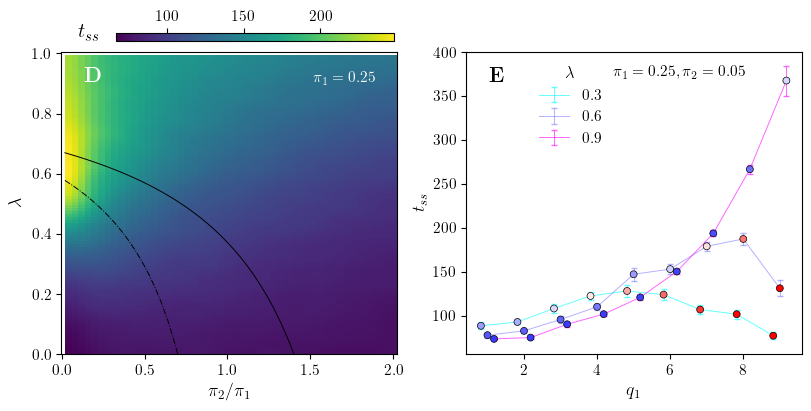

In [4]:
latexFont(titlesize=11, ticklabelssize=11, labelsize=13)
# fig, ax = plt.subplots(2,3, figsize=(12,8.2), constrained_layout=True)
fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

pathQline = getExternalSSDpath() + getProjectFoldername() + '/det_sols_from_polynomial/res_files'
pi1 = 0.25
q1, q2 = 7, 10
sigma = 2
map = np.load(f'{getTimeEvosPath()}/stat_times_maps/map_times_sim_asym_fixPi1_q1_{q1}_q2_{q2}_pi1_{pi1}.npz')
map_filtered = gaussian_filter(map['time'], sigma=sigma)
im = ax[0].pcolormesh(map['x']/pi1, map['y'], map_filtered, cmap='viridis', shading='nearest', rasterized=True)
fig.colorbar(im, ax=ax[0], location='top', fraction=0.05, aspect=35, pad=0.02, shrink=0.83, anchor=(0.96, 1.0))
for x,ls in zip([1, 2], ['-.', '-']):
    tline = pd.read_csv(f'{pathQline}/Tline_asym_fixPi1_pi1_{pi1}_q1_{float(q1)}_q2_{float(q2)}_f2_{int(x)}f1.csv')
    tline = tline.query('pi2 >= 0.005')
    tline = tline.rename(columns={'lambda':'l'})
    i_last_pi2 = tline.query('l != l').iloc[0].name
    tline.at[i_last_pi2, 'l'] = 0.0
    ax[0].plot(tline['pi2']/pi1, tline['l'], color='xkcd:black', lw=0.7, ls=ls)
ax[0].set_xlabel('$\pi_{2}/\pi_1$')
ax[0].set_ylabel('$\lambda$')
ax[0].set_xlim(-0.005, None)
ax[0].set_ylim(0.0, 1.005)
# ax[0].axvline(pi1, ls=':', color='xkcd:black', lw=0.8)
fig.text(0.09, 0.92, r"$t_{ss}$", color='xkcd:black')



N, pi1, pi2, q2 = 5000, 0.25, 0.05, 10
q1s = [1,2,3,4,5,6,7,8,9]
# block size, threshold and gaussian filter:
w, t, sig = 50, 5e-4, 0
lambs = [0.3,0.6,0.9]
colors = plt.cm.cool(np.linspace(0,1,len(lambs)))
jitterer_ls_q1 = np.linspace(-0.18,0.18, len(lambs))

for l,c,jitterer in zip(lambs,colors,jitterer_ls_q1):
    times_q1, times_q1_sigma, Qs_q1 = [], [], []
    for q1 in q1s:
        # get the dataframes with the time evolutions:
        folder = f'time_evo_csv_N_{N}_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}'
        if not os.path.exists(f'{getTimeEvosPath()}/{folder}'):
            simEvo(pi1, pi2, q1, q2, l, N, ic='N', bots_per_site = [N, 0, 0], max_time = 1000, Nrea=25, lround=1)
        files = glob.glob(f'{getTimeEvosPath()}/{folder}/*')
        dfs = [pd.read_csv(file) for file in files]
        times, Qs = [], []
        for df in dfs:
            # time = search_time(w=10, t=0.0005, evo=df['f2'], sig=20)
            time = search_time(w=w, t=t, evo=df['f2'], sig=sig)
            times.append(time)
            # check value of consensus:
            # df['Q'] = df['f2'] - 2*df['f1']
            # Q = np.average(df['Q'].iloc[time:])
            df['f0x1'] = np.maximum(df['f0'], x*df['f1'])
            df['Qmod'] = df['f2'] - df['f0x1']
            Q = np.average(df['Qmod'].iloc[time:])
            Qs.append(Q)
        times_q1.append(np.average(times)), times_q1_sigma.append(np.std(times)/np.sqrt(len(dfs))), Qs_q1.append(np.average(Qs))
    ax[1].errorbar(q1s+jitterer, times_q1, times_q1_sigma, capsize=2.0, elinewidth=0.7, lw=0.7, marker=None, color=c, alpha=0.6, label=f'{l}', zorder=-1)
    points = ax[1].scatter(q1s+jitterer, times_q1, c=Qs_q1, cmap='bwr_r', vmin=-1, vmax=1, marker='.', s=100, linewidths=0.5, edgecolors='k')
ax[1].set(xlabel='$q_1$', ylabel=r'$t_{ss}$')
ax[1].legend(loc=(0.2, 0.67), title=r'$\lambda$', fontsize=11, title_fontsize=12, ncols=1, frameon=False)

ax[0].text(0.07,0.9, r'$\textbf{D}$', color='xkcd:white', transform=ax[0].transAxes)
ax[1].text(0.07,0.9, r'$\textbf{E}$', transform=ax[1].transAxes)

ax[0].text(0.75,0.9, r'$\pi_1 = 0.25$', color='xkcd:white', transform=ax[0].transAxes, fontsize=11)
ax[1].text(0.44,0.92, r'$\pi_1 = 0.25, \pi_2 = 0.05$', transform=ax[1].transAxes, fontsize=11)
# ax[1].text(0.44,0.83, r'$\pi_2 = 0.05$', transform=ax[1].transAxes, fontsize=11)

fig.savefig(f'times_combine_w_Q_asym_fixPi1_pi1_{pi1}_multiplot.pdf')